In [1]:
import networkx as nx
from math import comb
import sympy
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import IPython.display as disp
import pandas as pd
import networkx as nx
from scipy import stats
import matplotlib as mpl
from datetime import datetime
from joblib import Parallel, delayed
from networkx.utils import py_random_state
from itertools import combinations, groupby
import random, time, pickle, random, multiprocessing, matplotlib, copy, itertools

nk,alpha,p=sympy.Symbol("n_k"),sympy.Symbol(r"\alpha"),sympy.Symbol("p")


def pk(k,quarantines):
    """Probability of infection after k trials given the node is not infected before.
    """
    if quarantines:
        return p*(1-alpha)**k #quarantines
    else:
        return 1-(1-p)*(1-alpha)**(k-1) #the original complex contagion
    

def pkn(k,n,quarantines): # does this work for quarantines? we don't need to forget the quarantine outcome here
    """Same as pk, but when there are n infected neighbors simultaneously trying to infect.
    """
    if quarantines:
        prob=0
        for act in range(n):
            prob=prob+(alpha-1)**(act)*(pk(k+1,quarantines)-1)**(act)*pk(k+1,quarantines)
        return prob
    else:
        prob=1
        for act in range(n):
            prob=prob*(1-pk(k+1+act,quarantines))
        return 1-prob

def process_motif(node,graph,processed,notprocessed,quarantines,singleinftrial=True):
    nsus,ninf,nrec = node
    n=nsus+ninf+nrec
    if ninf>0:
        exp=0
        #Infect others in this clique
        for newinf in range(1,nsus+1):
            #Create the new node
            newnode=(nsus-newinf,newinf,nrec+ninf)
            if newnode not in processed:
                notprocessed.add(newnode)
            
            #Link from this node to the new node 
            if singleinftrial:
                prob=comb(nsus,newinf)*(pk(nrec,quarantines)**newinf)*((1-pk(nrec,quarantines))**(nsus-newinf))
            else:
                prob=comb(nsus,newinf)*(pkn(nrec,ninf,quarantines)**newinf)*((1-pkn(nrec,ninf,quarantines))**(nsus-newinf))
            #prob=comb(nsus,newinf)*(pk(nrec,quarantines)**newinf)*((1-pk(nrec,quarantines))**(nsus-newinf))
            graph.add_edge(node,newnode,weight=prob)
            exp=exp+newinf*prob
        
        #Infect new cliques
        if nsus>0:
            graph.add_edge(node,(n-1,1,0),weight=(nk-1)*exp)
            #graph.add_edge(node,(n-1,1,0),weight=nsus*(nk-1)*pkn(nrec,ninf,quarantines))
            
def pkn_persistent(n):
    """Same as pk, but when there are n infected neighbors simultaneously trying to infect.
    Note that this doesn't depend on k.
    """ 
    prob=0
    for act in range(n):
        prob=prob+(alpha-1)**(act)*(p-1)**(act)*p
    return prob


def process_motif_persistent(node,graph,processed,notprocessed,quarantines,singleinftrial=True):
    nsus,ninf,nrec = node
    n=nsus+ninf+nrec
    if ninf>0:
        exp=0 #expected number of infected nodes
        #Infect others in this clique
        for newinf in range(1,nsus+1): #number of newly infected
            for newrec in range(0,nsus+1-newinf): #number of newly quarantined
                #Create the new node
                newnode=(nsus-newinf-newrec,newinf,nrec+ninf+newrec)
                assert sum(newnode)==sum(node),(node,newnode)
                if newnode not in processed:
                    notprocessed.add(newnode)

                #Link from this node to the new node    
                if singleinftrial:
                    prob=comb(nsus,newinf)*comb(nsus-newinf,newrec)*p**newinf*(1-p)**(nsus-newinf-newrec)*alpha**newrec*(1-alpha)**(nsus-newrec)
                else:
                    prob=comb(nsus,newinf)*comb(nsus-newinf,newrec)*pkn_persistent(ninf)**newinf*(1-pkn_persistent(ninf))**(nsus-newinf-newrec)*alpha**newrec*(1-alpha)**(nsus-newrec)
                graph.add_edge(node,newnode,weight=prob)
                exp=exp+newinf*prob
            
        
        #Infect new cliques
        if nsus>0:
            graph.add_edge(node,(n-1,1,0),weight=(nk-1)*exp)
                  
def motif_graph(motifsize,quarantines=False,persistent=False,singleinftrial=True):
    """Creates a motif graph where nodes are motifs and links are weighted with probabilities of producing
    new motifs in one time step.
    
    Nodes are tuples with three items with following convention:
    (number of susceptible nodes, number of infected nodes, number of recovered nodes)
    
    Parameters
    ----------
    motifsize : The number of nodes in the motif
    quarantines : If 
    """
    if persistent:
        assert quarantines, "Persistent only works with quarantines."
    graph=nx.DiGraph()
    notprocessed=set([(motifsize-1,1,0)])
    processed=set()
    while len(notprocessed)>0:
        node = notprocessed.pop()
        processed.add(node)
        if persistent:
            process_motif_persistent(node,graph,processed,notprocessed,quarantines,singleinftrial)
        else:
            process_motif(node,graph,processed,notprocessed,quarantines,singleinftrial)
    return graph

def canonical_node_order(graph):
    nodes=sorted(graph.nodes(),key=lambda x:list(reversed(x))) #canonical order for nodes
    return nodes

def canonical_node_map(graph):
    nodes=canonical_node_order(graph)
    nodeid=dict(((node,i+1) for i,node in enumerate(nodes)))
    return nodeid

def get_M_matrix(graph,verbose=False):
    nodes=canonical_node_order(graph)
    nodeid=canonical_node_map(graph)
    M=sympy.matrices.zeros(len(nodes),len(nodes))
    if verbose: print(r"$(i,j)$ & $m_{ij}$ \\")
    for node in nodes:
        for neigh in sorted(graph.predecessors(node),key=lambda x:nodeid[x]):
            if verbose: print("$(",nodeid[node],",",nodeid[neigh],")$&",end="")
            if verbose: print("$",sympy.latex(sympy.simplify(graph[neigh][node]['weight'])),r"$\\")
            
            M[nodeid[node]-1,nodeid[neigh]-1]=graph[neigh][node]['weight']
    return M

def numeric_find_alpha(M,nkval,pval):
    Mn=M.subs(nk,nkval).subs(p,pval)
    n=len(M[0,:])
    try:
        alphaval=scipy.optimize.bisect(lambda x:sympy.det(Mn.subs(alpha,x)- sympy.eye(n)),0,1,xtol=0.0001)
        return alphaval
    except ValueError:
        return np.NaN



In [2]:
g=motif_graph(4,quarantines=True,persistent=True,singleinftrial=False)
M=get_M_matrix(g)
Ms=M.subs(nk,3).subs(alpha,0)

g2=motif_graph(4,quarantines=True,persistent=False,singleinftrial=False)
M2=get_M_matrix(g2)
Ms2=M2.subs(nk,3).subs(alpha,0)
#g[(1, 1, 2)]
Ms-Ms2

Matrix([
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0]])

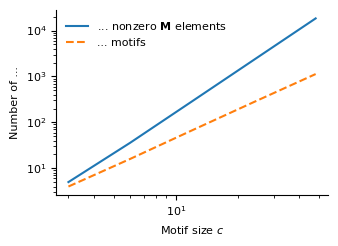

In [3]:
import pickle


"""
ks=[3,6,12,24,48]
nodes=[]
edges=[]
for kval in ks:
    print(kval)
    g=motif_graph(kval)
    nodes.append(g.number_of_nodes())
    edges.append(g.number_of_edges())
    
with open('motif_sizes.pickle', 'wb') as fn:
    pickle.dump((ks,nodes,edges), fn)
"""
    
with open('motif_sizes.pickle', 'rb') as fn:
    (ks,nodes,edges) = pickle.load(fn)


plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=8)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('figure', titlesize=8)  # fontsize of the figure title

fig,ax=plt.subplots(figsize=(3.42,2.5))
ax.loglog(ks,edges,label=r'... nonzero $\mathbf{M}$ elements')
ax.loglog(ks,nodes,'--',label=r'... motifs')
ax.set_xlabel(r"Motif size $c$")
ax.set_ylabel(r"Number of ...")
ax.legend(frameon=False)
ax.spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig("motif_sizes.pdf")


In [2]:
import numpy as np

def power_iteration(A, tolerance=1e-4):
    #b_k = np.random.rand(A.shape[1])
    b_k = np.ones(A.shape[1])
    b_k1 = np.dot(A, b_k)
    b_k1_norm = np.linalg.norm(b_k1)
    b_k = b_k1 / b_k1_norm
    iterations = 0

    while True:
        iterations += 1
        # Calculate the matrix-by-vector product A*b_k
        b_k1 = np.dot(A, b_k)
        
        # Re-normalize the vector
        b_k1_norm = np.linalg.norm(b_k1)
        b_k_next = b_k1 / b_k1_norm
        
        # Check for convergence
        if np.linalg.norm(b_k_next - b_k) < tolerance:
            break
        
        b_k = b_k_next
    
    # The dominant eigenvalue can be found using the Rayleigh quotient
    dominant_eigenvalue = np.dot(b_k.T, np.dot(A, b_k)) / np.dot(b_k.T, b_k)

    #return (dominant_eigenvalue, b_k, iterations)
    return dominant_eigenvalue

def power_iteration_n(A, num_simulations: int):
    # Randomly initialize a vector b of length equal to the matrix A's number of columns
    b_k = np.random.rand(A.shape[1])
    
    # Run the power iteration algorithm for a number of iterations
    for _ in range(num_simulations):
        # Calculate the matrix-by-vector product A*b_k
        b_k1 = np.dot(A, b_k)
        
        # Re-normalize the vector
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1 / b_k1_norm

    # The dominant eigenvalue 
    dominant_eigenvalue = np.dot(b_k.T, np.dot(A, b_k)) / np.dot(b_k.T, b_k)

    return dominant_eigenvalue



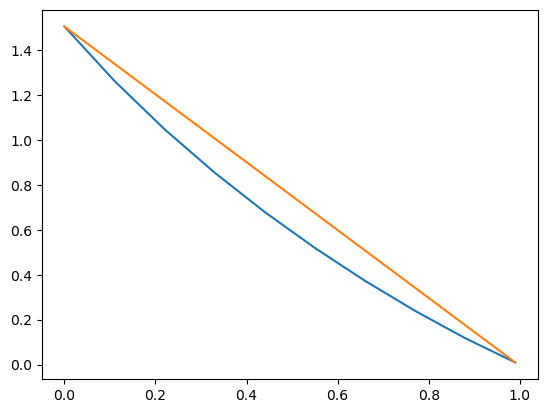

In [3]:
def get_res(alphas,p_val,c_val,nk_val):
    g=motif_graph(c_val,quarantines=True,persistent=True,singleinftrial=False)
    M=get_M_matrix(g)

    res=[]
    for a in alphas:
        #mn=M.subs(nk,2).subs(alpha,a).subs(p,0.1)
        #re=max(map(lambda x:sympy.re(x),mn.eigenvals().keys()))
        mn=np.array(M.subs(nk,nk_val).subs(alpha,a).subs(p,p_val)).astype(np.float64)
        #re=power_iteration_n(mn,10)
        re=max(abs(scipy.linalg.eig(mn)[0]))
        res.append(re)
    return res
        
alphas=np.linspace(0,0.99,10)
res=get_res(alphas,0.1,10,2)
plt.plot(alphas,res)
plt.plot([alphas[0],alphas[-1]],[res[0],res[-1]])

In [4]:
alpha_range=np.linspace(0,0.99,30)
cs1=[2,3,4]
r=6
rs_list1=[]
for c in cs1:
    nk_val=r/(c-1)
    rs_list1.append(get_res(alpha_range,0.5,c,nk_val))
    
cs2=[6,11,16]
r=30
rs_list2=[]
for c in cs2:
    nk_val=r/(c-1)
    rs_list2.append(get_res(alpha_range,0.1,c,nk_val))


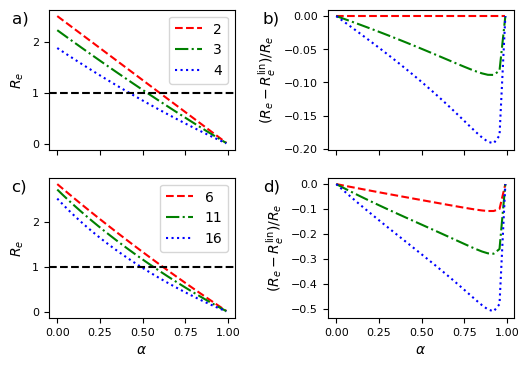

In [5]:
_i =0
cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
markers = ['*', '^', 'o']

plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['font.size']= 10


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(6, 4),sharex=True) #revtex column width would be 3.4 inch



for i,c in enumerate(cs1):
    rs = rs_list1[i] 
    ax1.plot(alpha_range, rs, color = cr[i],linestyle=lins[i], markersize = 10,label=c)
    ax2.plot(alpha_range, (rs-np.linspace(rs[0],rs[-1],len(rs)))/rs, color = cr[i],linestyle=lins[i], markersize = 10)

#ax1.set_xlabel(r'$\alpha$', fontsize= '10')
ax1.set_ylabel(r'$R_e$')
#ax2.set_xlabel(r'$\alpha$', fontsize= '10')
ax2.set_ylabel(r'$(R_e-R_e^{\mathrm{lin}})/R_e$')
ax1.axhline(y = 1, color = 'black', linestyle = '--')
ax1.set_yticks(range(3))
ax1.legend(loc = 'upper right')
ax1.text(-0.2, 0.99, "a)", transform=ax1.transAxes, fontsize=12,va='top')
ax2.text(-0.35, 0.99, "b)", transform=ax2.transAxes, fontsize=12,va='top')

for i,c in enumerate(cs2):
    rs = rs_list2[i] 
    ax3.plot(alpha_range, rs, color = cr[i],linestyle=lins[i], markersize = 10,label=c)
    ax4.plot(alpha_range, (rs-np.linspace(rs[0],rs[-1],len(rs)))/rs, color = cr[i],linestyle=lins[i], markersize = 10)

ax3.set_xlabel(r'$\alpha$')
ax3.set_ylabel(r'$R_e$')
ax4.set_xlabel(r'$\alpha$')
ax4.set_ylabel(r'$(R_e-R_e^{\mathrm{lin}})/R_e$')
ax3.axhline(y = 1, color = 'black', linestyle = '--')
ax3.set_yticks(range(3))
ax3.legend(loc = 'upper right')
ax3.text(-0.2, 0.99, "c)", transform=ax3.transAxes, fontsize=12,va='top')
ax4.text(-0.35, 0.99, "d)", transform=ax4.transAxes, fontsize=12,va='top')

np.save('auto_rs_list1', rs_list1)
np.save('auto_rs_list2', rs_list2)


fig.subplots_adjust(wspace=0.5)



In [69]:
fig.savefig("Re_both.pdf",bbox_inches='tight')

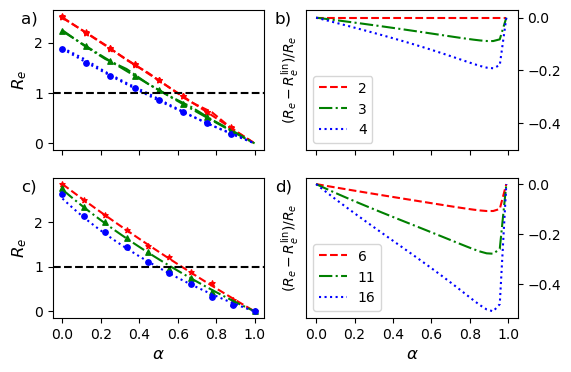

In [111]:
rs_list = np.load(str(0.5)+'Ro'+str(5*10**5)+'.npy')
rs_list_ = np.load(str(0.1)+'Ro30_'+str(10**5)+'.npy')
alpha_range = np.linspace(0, 1, 10)
df = pd.read_csv('parsweep_noncc_4.csv')


rs_list1 = np.load('auto_rs_list1.npy')
rs_list2 = np.load('auto_rs_list2.npy')
alpha_range_M=np.linspace(0,0.99,30)

cs1=[2,3,4]
cs2=[6,11,16]

cr = ['r', 'g', 'b']
lins = ['dashed', 'dashdot', 'dotted']
markers = ['*', '^', 'o']

plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['font.size']= 10


fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(6, 4),sharex=True) #revtex column width would be 3.4 inch


_i =0


for i,c in enumerate(cs2):
    #Simulation
    rs = rs_list_[i]
    ax3.scatter(alpha_range, rs,  color = cr[i],marker=markers[i], s = 15)
    
    
for i,c in enumerate(cs1):
    #Simulation
    rs = rs_list[c-2]
    ax1.plot(alpha_range, rs,  color = cr[_i],linestyle=lins[_i], markersize = 15)
    if c ==2:
        data_p_1 = df[(df.p > .499) & (df.p < .506)]
        david_alpha = data_p_1['alpha'].to_numpy()
        ax1.scatter(david_alpha[::25][::2], data_p_1['lmax_value_'+str(c)].to_numpy()[::25][::2], marker=markers[i], color = cr[_i], s = 15)   

    else:
        data_p_1 = df[(df.p > .499) & (df.p < .5025)]
        david_alpha = data_p_1['alpha'].to_numpy()
        ax1.scatter(david_alpha[::25][::2], data_p_1['lmax_value_'+str(c)].to_numpy()[::25][::2], marker=markers[i], color = cr[_i],  s = 15)   
    _i += 1
    
    

    #Mean-Field
    rs = rs_list1[i] 
    ax1.plot(alpha_range_M, rs, color = cr[i],linestyle=lins[i], markersize = 15,label=c)
    ax2.plot(alpha_range_M, (rs-np.linspace(rs[0],rs[-1],len(rs)))/rs, color = cr[i],linestyle=lins[i], markersize = 10, label=c)

#ax1.set_xlabel(r'$\alpha$', fontsize= '10')
ax1.set_ylabel(r'$R_e$', fontsize=12)
#ax2.set_xlabel(r'$\alpha$', fontsize= '10')
ax2.set_ylabel(r'$(R_e-R_e^{\mathrm{lin}})/R_e$')
ax1.axhline(y = 1, color = 'black', linestyle = '--')
ax1.set_yticks(range(3) )
ax2.set_ylim([-.5, 0.03])

ax2.legend()
ax1.text(-0.15, 0.99, "a)", transform=ax1.transAxes, fontsize=12,va='top')
ax2.text(-0.15, 0.99, "b)", transform=ax2.transAxes, fontsize=12,va='top')

for i,c in enumerate(cs2):
    rs = rs_list2[i] 
    ax3.plot(alpha_range_M, rs, color = cr[i],linestyle=lins[i], markersize = 15,label=c)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    ax4.plot(alpha_range_M, (rs-np.linspace(rs[0],rs[-1],len(rs)))/rs, color = cr[i],linestyle=lins[i], markersize = 10, label=c)
    

ax3.set_xlabel(r'$\alpha$', fontsize=12)
ax3.set_ylabel(r'$R_e$', fontsize=12)
ax4.set_xlabel(r'$\alpha$', fontsize=12)
ax4.set_ylabel(r'$(R_e-R_e^{\mathrm{lin}})/R_e$')
ax3.axhline(y = 1, color = 'black', linestyle = '--')
ax3.set_yticks(range(3))
ax4.legend()
ax3.text(-0.15, 0.99, "c)", transform=ax3.transAxes, fontsize=12,va='top')
ax4.text(-0.15, 0.99, "d)", transform=ax4.transAxes, fontsize=12,va='top')
#ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax2.tick_params(axis='y', labelsize=10)
ax4.tick_params(axis='y', labelsize=10)

ax1.tick_params(axis='y', labelsize=10)
ax3.tick_params(axis='y', labelsize=10)

ax3.tick_params(axis='x', labelsize=10)
ax4.tick_params(axis='x', labelsize=10)

In [112]:
fig.savefig("Re_both.pdf",bbox_inches='tight')

In [48]:
len(alpha_range_M[::2][::2])

8